# Создание модели для прогнозирования оттока клиентов.

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.utils import shuffle
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/datasets/Churn.csv')

In [2]:
display(df.head())
print('------------------')
display(df.info())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

Удалим ненужные для обучения модели столбцы индекса строки, уникального идентификатора и фамилии клиента:

In [3]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

Сравним распределение целевого признака во всём датасете и в строках с пропущенными значениями столбца "Tenure":

In [4]:
df['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

In [5]:
df[df['Tenure'].isna()]['Exited'].value_counts(normalize=True)

0    0.79868
1    0.20132
Name: Exited, dtype: float64

Заполним пропуски в столбце "Tenure" медианным значением, сгруппировав по стране проживания, полу и возрасту:

In [6]:
df['Tenure'] = df['Tenure'].fillna(df.groupby(['Geography', 'Gender', 'Age'])['Tenure'].transform('median').round())

Проверим, остались ли ещё пропуски в столбце:

In [7]:
df[df['Tenure'].isna()]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1678,570,France,Female,18,NaN,82767.42,1,1,0,71811.90,0
4556,681,France,Female,18,NaN,98894.39,1,1,1,9596.40,0
4644,712,Spain,Male,74,NaN,0.00,2,0,0,151425.82,0


Т.к. количество строк крайне мало по отношению ко всему датасету, удалим данные строки:

In [8]:
df.dropna(inplace=True)

С помощью прямого кодирования преобразуем категориальные признаки "Страна проживания" и "Пол" в численные:

In [9]:
df_ohe = pd.get_dummies(df, drop_first=True)

Оценим мультиколинеарность признаков:

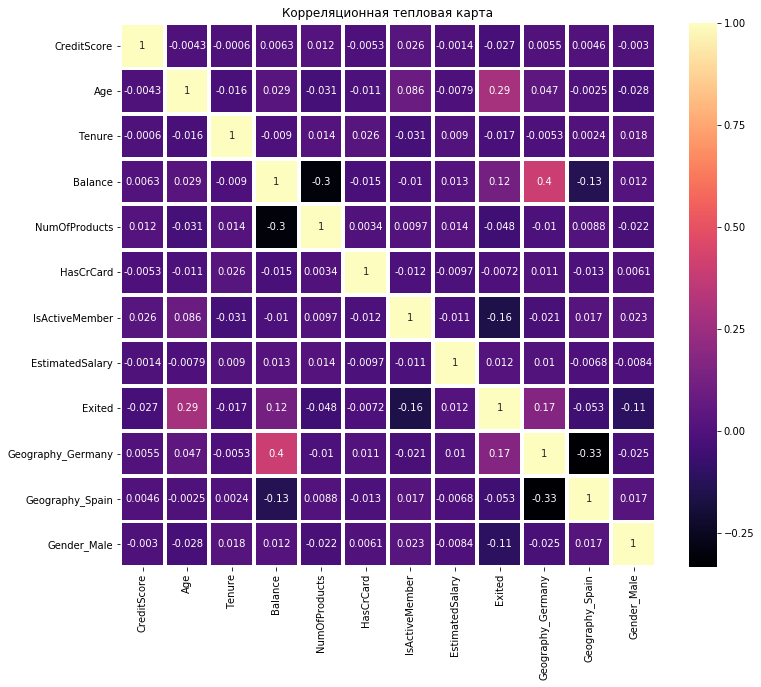

In [10]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(df_ohe.corr(), annot=True, linewidths=3, cmap= 'magma')
ax.set_title('Корреляционная тепловая карта')
plt.show()

Сильной зависимости между признаками не выявлено. Поэтому используем их все при обучении.

Приведём признаки к одному масштабу с помощью стандартизации:

In [11]:
features = df_ohe.drop('Exited', axis=1) #выделение признаков
target = df_ohe['Exited'] #выделение целевого признака

#выделение валидационной выборки:
features_rest, features_valid, target_rest, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=12345)

#выделение обучающей и тестовой выборок:
features_train, features_test, target_train, target_test = train_test_split(
    features_rest, target_rest, test_size=0.25, random_state=12345)

#стандартизация признаков:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()

scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### Вывод.
В ходе подготовки данных были удалены ненужные столбцы и пропущенные значения в столбце "Tenure"; преобразованы категориальные значения; выделены обучающая, валидационная и тестовая выборки; проведена стандартизация признаков.

## Исследование задачи

Оценим распределение целевого признака:

In [12]:
target.value_counts(normalize=True)

0    0.796239
1    0.203761
Name: Exited, dtype: float64

Посчитаем F1-меру для логистической регрессии:

In [13]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

f1_score(target_valid, predicted_valid)

0.27624309392265195

Посчитаем F1-меру для дерева решений:

In [15]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

f1_score(target_valid, predicted_valid)

0.49596309111880044

Посчитаем F1-меру для случайного леса:

In [17]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

f1_score(target_valid, predicted_valid)

0.5426829268292682

### Вывод.
Между классами целевого признака имеется сильный дисбаланс. В данном случае наибольшую F1-меру имеет модель случайного леса.

## Борьба с дисбалансом

Для борьбы с дисбалансом применим следующие техники: взвешивание классов, увеличение и уменьшение выборки.

### Взвешивание классов.

#### Логистическая регрессия

In [18]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('F1-мера:', f1_score(target_valid, predicted_valid))
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid))

F1-мера: 0.5253940455341506
AUC-ROC: 0.7845820816265745


#### Дерево решений

In [19]:
best_model = None
best_f1 = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
        
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    f1 = f1_score(target_valid, predicted_valid)
    
    if f1 > best_f1:
        best_model = model
        best_f1 = f1
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('F1-мера:', best_f1)
print('AUC-ROC:', auc_roc)

F1-мера: 0.5714285714285715
AUC-ROC: 0.8119777242579641


#### Случайный лес

In [20]:
best_model = None
best_f1 = 0
for depth in range(1, 11):
    for est in range(1, 51):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
    
        f1 = f1_score(target_valid, predicted_valid)
    
        if f1 > best_f1:
            best_model = model
            best_f1 = f1
            auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('F1-мера:', best_f1)
print('AUC-ROC:', auc_roc)
best_model

F1-мера: 0.565149136577708
AUC-ROC: 0.8640274144464384


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

### Увеличение выборки.

In [21]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

#### Логистическая регрессия

In [22]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('F1-мера:', f1_score(target_valid, predicted_valid))
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid))

F1-мера: 0.5094768764215315
AUC-ROC: 0.7852003508038251


#### Дерево решений

In [23]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 2)

best_model = None
best_f1 = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)

    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    f1 = f1_score(target_valid, predicted_valid)
    
    if f1 > best_f1:
        best_model = model
        best_f1 = f1
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('F1-мера:', best_f1)
print('AUC-ROC:', auc_roc)
best_model

F1-мера: 0.6245259165613147
AUC-ROC: 0.814313157099039


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

#### Случайный лес

In [24]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

best_model = None
best_f1 = 0
for depth in range(1, 11):
    for est in range(1, 51):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
    
        f1 = f1_score(target_valid, predicted_valid)
    
        if f1 > best_f1:
            best_model = model
            best_f1 = f1
            auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('F1-мера:', best_f1)
print('AUC-ROC:', auc_roc)
best_model

F1-мера: 0.6440281030444964
AUC-ROC: 0.8675941205760282


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=47,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

### Уменьшение выборки.

In [25]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

#### Логистическая регрессия

In [26]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('F1-мера:', f1_score(target_valid, predicted_valid))
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid))

F1-мера: 0.5123809523809524
AUC-ROC: 0.7828491227647913


#### Дерево решений

In [27]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)

best_model = None
best_f1 = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=7)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)

    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    if f1 > best_f1:
        best_model = model
        best_f1 = f1
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('F1-мера:', best_f1)
print('AUC-ROC:', auc_roc)
best_model

F1-мера: 0.6320754716981132
AUC-ROC: 0.8080371984433455


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

#### Случайный лес

In [28]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.4)

best_model = None
best_f1 = 0
for depth in range(1, 11):
    for est in range(1, 51):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)

        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]

        if f1 > best_f1:
            best_model = model
            best_f1 = f1
            auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('F1-мера:', best_f1)
print('AUC-ROC:', auc_roc)
best_model

F1-мера: 0.6320754716981132
AUC-ROC: 0.6112794260777215


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=1, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

### Вывод.
В результате наибольшее значение F1-меры удалось получить при увеличении выборки на модели случайного леса.

## Тестирование модели

Проверим модель на тестовой выборке.

In [29]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

model = RandomForestClassifier(random_state=12345, max_depth=8, n_estimators=47)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print('F1-мера:', f1_score(target_test, predicted_test))
print('AUC-ROC:', roc_auc_score(target_test, probabilities_one_test))

F1-мера: 0.63121387283237
AUC-ROC: 0.8704819512867115


## Вывод.

По ходу работы на этапе подготовки данных с помощью прямого кодирования были преобразованы категориальные признаки, а также была проведена стандартизация признаков. Были испытаны модели логистической регрессии, случайного леса и дерева решений. Для получения наилучших значений F1-меры и AUC-ROC была проведена балансировка с помощью взвешивания классов, увеличения и уменьшения выборки. 

В результате наилучшие значения метрик удалось получить на модели случайного леса с максимальной глубиной - 8 и количеством деревьев - 47 с применением техники увеличения выборки.